<a href="https://colab.research.google.com/github/zhe0/prac/blob/main/simple_rag_by_gguf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

rag chatbot example
* 偏小的語言模組
* 減少幻覺程度

In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

!pip install wandb
import wandb

!pip install -q kaggle
!chmod 600 ~/kaggle.json # 設定權限，確保只有使用者可以讀取
!cp kaggle.json /root/.config/kaggle/ # move the key to the folder
import kaggle
print("Kaggle API 憑證設定完成！")


# 3. 下載 Kaggle Dataset
# ------------------------------------
# **重要:** 你需要知道你要下載的 Kaggle Dataset 的名稱 (通常是 'owner/dataset-name')
# 例如，如果要下載 'creditcardfraud' 這個資料集 (示範用，你可以替換成你的資料集)
dataset_name = 'mlg-ulb/creditcardfraud' #  <--  請在這裡替換成你要下載的 Kaggle Dataset 名稱

output_path = './kaggle_data' # 設定資料集下載的路徑 (Colab notebook 的當前目錄下的 kaggle_data 資料夾)
!mkdir -p {output_path} # 建立資料夾 (如果不存在)

print(f"正在下載 Kaggle Dataset: {dataset_name} 到 {output_path}...")
!kaggle datasets download -d {dataset_name} -p {output_path}
print("Kaggle Dataset 下載完成！")


# 4. 解壓縮下載的資料集 (如果需要)
# ------------------------------------
# Kaggle Dataset 通常會下載成 zip 檔案，需要解壓縮才能讀取裡面的資料檔案
import zipfile

zip_file_path = os.path.join(output_path, f'{dataset_name.split("/")[1]}.zip') # 假設下載的 zip 檔名與 dataset name 相關
extract_path = output_path # 解壓縮到同一個 output_path 資料夾

print(f"正在解壓縮檔案: {zip_file_path} 到 {extract_path}...")
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("資料集解壓縮完成。")
except FileNotFoundError:
    print(f"找不到 zip 檔案: {zip_file_path}。 如果下載的不是 zip 檔案，請跳過此步驟。")


# 5. 讀取資料到 Pandas DataFrame (假設資料是 CSV 格式)
# ------------------------------------
csv_file_name = 'creditcard.csv' # <-- 請根據你的資料集修改 CSV 檔案名稱 (如果適用)
csv_file_path = os.path.join(extract_path, csv_file_name) # 假設 CSV 檔案在解壓縮後的資料夾中

print(f"正在讀取 CSV 檔案: {csv_file_path}...")
try:
    df = pd.read_csv(csv_file_path)
    print("CSV 檔案讀取成功，Pandas DataFrame 資訊:")
    print(df.head()) # 印出 DataFrame 的前幾行
    print(df.info()) # 印出 DataFrame 的資訊 (欄位名稱, 資料型別, 非空值數量等)

    # 6. 將 Pandas DataFrame 轉換成 PyTorch Tensor (範例)
    # ------------------------------------
    # # 假設你要使用 'V1', 'V2', 'Amount' 這些欄位作為特徵
    # feature_cols = ['V1', 'V2', 'Amount'] # <-- 請根據你的需求修改特徵欄位
    features = df[[i for i in df.columns if not i == 'Class']].values # 取得特徵值 (NumPy array)
    features_tensor = torch.tensor(features, dtype=torch.float32) # 轉換成 PyTorch FloatTensor

    # 如果有 'Class' 欄位作為標籤
    if 'Class' in df.columns:
        labels = df['Class'].values # 取得標籤值 (NumPy array)
        labels_tensor = torch.tensor(labels, dtype=torch.long) # 轉換成 PyTorch LongTensor (整數標籤)
        print("\n特徵 Tensor (features_tensor) shape:", features_tensor.shape)
        print("標籤 Tensor (labels_tensor) shape:", labels_tensor.shape)
    else:
        print("\n特徵 Tensor (features_tensor) shape:", features_tensor.shape)
        print("沒有 'Class' 欄位，僅轉換特徵 Tensor。")


    print("\n--- 從 Kaggle Dataset 讀取資料流程完成 ---")

except FileNotFoundError:
    print(f"找不到 CSV 檔案: {csv_file_path}。 請檢查檔案路徑和檔案名稱是否正確。")
except Exception as e:
    print(f"讀取 CSV 檔案時發生錯誤: {e}")


chmod: cannot access '/root/kaggle.json': No such file or directory
Kaggle API 憑證設定完成！
正在下載 Kaggle Dataset: mlg-ulb/creditcardfraud 到 ./kaggle_data...
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
Kaggle Dataset 下載完成！
正在解壓縮檔案: ./kaggle_data/creditcardfraud.zip 到 ./kaggle_data...
資料集解壓縮完成。
正在讀取 CSV 檔案: ./kaggle_data/creditcard.csv...
CSV 檔案讀取成功，Pandas DataFrame 資訊:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   


In [71]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask,
                              key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt


class TransformerAutoencoder(nn.Module):
    def __init__(self, feature_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super().__init__()
        self.embedding_encoder = nn.Linear(feature_size, d_model) # 輸入特徵 Embedding 層
        self.embedding_decoder = nn.Linear(d_model, feature_size) # 輸出特徵 De-embedding 層 (用於重建)

        # Encoder 層堆疊
        encoder_layers = [TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_encoder_layers)]
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder 層堆疊
        decoder_layers = [TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout) for _ in range(num_decoder_layers)]
        self.decoder = nn.Sequential(*decoder_layers)


    def forward(self, src):
        # Encoder 部分
        enc_src = self.embedding_encoder(src) # 將輸入特徵轉換到 d_model 維度 [batch_size, seq_len, d_model]
        memory = self.encoder(enc_src)       # 通過 Encoder 層 [batch_size, seq_len, d_model]

        # Decoder 部分 - 正確的 Sequential 迭代方式
        tgt = memory # 初始化 decoder 的 input 為 encoder 的 memory (對於 Autoencoder 來說，通常將 encoder 的輸出作為 decoder 的初始輸入)
        for decoder_layer in self.decoder: # 迭代 self.decoder (nn.Sequential 容器) 中的每一層
            tgt = decoder_layer(tgt, memory) # 顯式調用每個 decoder_layer 的 forward 方法，並傳遞 tgt 和 memory

        output = self.embedding_decoder(tgt) # [batch_size, seq_len, feature_size]
        return output

In [59]:
# 2. 從 CSV 檔案載入資料並準備訓練/測試集
# ------------------------------------
def load_and_prepare_data(csv_file='transaction_data.csv', feature_cols=None, test_size=100):
    """
    從 CSV 檔案載入資料，選擇特徵欄位，並分割成訓練集和測試集。

    Args:
        csv_file (str): CSV 檔案路徑 (假設已上傳到 Colab).
        feature_cols (list): 要使用的特徵欄位名稱列表.
        test_size (int): 測試集大小 (取最後幾 rows 作為測試集).

    Returns:
        tuple: 訓練集 (torch.Tensor), 測試集 (torch.Tensor), 真實標籤 (測試集, torch.Tensor, 如果 CSV 包含 'Class' 欄位).
    """
    df = pd.read_csv(csv_file)

    # 選擇特徵欄位
    if feature_cols is None:
        feature_cols = [i for i in df.columns if not i == 'Class'] # 假設 V1, V2, Amount 都是特徵欄位，或者使用全部
    X = df[feature_cols].values
    y = None # 預設沒有標籤
    if 'Class' in df.columns:
        y = df['Class'].values # 如果 CSV 包含 'Class' 欄位，則讀取標籤

    # 將資料轉換成 PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    if y is not None:
        y_tensor = torch.tensor(y, dtype=torch.long)
    else:
        y_tensor = None

    # 分割訓練集和測試集 (取最後 test_size rows 作為測試集)
    train_data = X_tensor[:-test_size]
    test_data = X_tensor[-test_size:]
    test_labels = None
    if y_tensor is not None:
        test_labels = y_tensor[-test_size:]

    return train_data, test_data, test_labels


In [89]:
# 3. 設定超參數和模型、優化器、損失函數
# ------------------------------------
feature_size = len(df.columns)-1 # 輸入特徵維度2 (V1, V2)
sequence_length = 1 # 每個樣本視為長度為 1 的序列 (因為我們目前是獨立處理每個 row)
d_model = 64       # Transformer 模型中的 embedding dimension
nhead = 2          # Multi-head attention head 數量
num_encoder_layers = 2 # Encoder 層數
num_decoder_layers = 2 # Decoder 層數
dim_feedforward = 128 # Feedforward network hidden layer dimension
dropout = 0.1
learning_rate = 0.0001 #0.001
epochs = 30        # 增加 epochs 讓模型有更多訓練機會
batch_size = 128 #32 ≒ 20%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 檢查是否有 GPU 可用，有的話使用 GPU 加速

model = TransformerAutoencoder(feature_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout).to(device)
model = model.float().to(device)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate) # 使用 Adam 優化器
# criterion = nn.HuberLoss(reduction='mean') # 使用均方誤差 (MSE) 作為重建誤差損失函數
criterion = nn.MSELoss(reduction='mean') # 使用均方誤差 (MSE) 作為重建誤差損失函數

In [94]:
# 4. 載入資料並建立 DataLoader
# ------------------------------------
train_data, test_data, test_labels = load_and_prepare_data(
    csv_file='/content/kaggle_data/creditcard.csv', # 假設你的 CSV 檔案名為 transaction_data.csv
    test_size=100                    # 使用最後 100 rows 作為測試集
)
# batch_size = 128 #32 ≒ 20%
from sklearn.preprocessing import StandardScaler
# 1. 初始化 StandardScaler
scaler = StandardScaler()

# 2. 在訓練資料上 fit scaler (學習均值和標準差)
scaler.fit(train_data)

# 3. 使用 *相同的 scaler* transform 訓練資料和驗證資料
train_data = torch.tensor(scaler.transform(train_data))
test_data = torch.tensor(scaler.transform(test_data))

# 建立訓練集 DataLoader
train_dataset = torch.utils.data.TensorDataset(train_data, train_data) # Autoencoder 的輸入和輸出都是相同的資料 (重建)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,pin_memory=True,num_workers=2)

# 建立測試集 DataLoader (注意: 測試集不需要 shuffle)
test_dataset = torch.utils.data.TensorDataset(test_data, test_data)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [95]:
run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    entity="my-team-name",
    # Set the wandb project where this run will be logged.
    project="my-project",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "architecture": "TransformerAutoencoder",
        "dataset": "mlg-ulb/creditcardfraud",
        "epochs": epochs,
    },
)

wandb.init()
!wandb login #822c95d929b2b454ea30fa73027dda0d9eee6258

wandb: Currently logged in as: r06341047 (r06341047-student) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [96]:
# 5. 訓練模型 (Fine-tuning)
# ------------------------------------
history = {'train_loss': []} # 紀錄訓練過程中的 loss
# scaler = torch.cuda.amp.GradScaler() # 建立 GradScaler

for epoch in range(epochs):
    model.train() # 設定模型為訓練模式
    train_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
        inputs = inputs.unsqueeze(1).to(device).float() # 將輸入資料增加一個 sequence length 維度 (batch_size, seq_len=1, feature_size), 並移動到 GPU (如果有的話)
        targets = targets.unsqueeze(1).to(device).float() # 同樣處理 targets

        optimizer.zero_grad() # 清空梯度
        # with torch.cuda.amp.autocast(): # 在 autocast 範圍內執行 forward pass
        #     outputs = model(inputs)
        #     loss = criterion(outputs, targets)
        # scaler.scale(loss).backward() # 使用 scaler.scale(loss) 進行反向傳播
        # scaler.step(optimizer)        # 使用 scaler.step(optimizer) 更新參數
        # scaler.update()              # 更新 scaler
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() # 累加 batch loss

    avg_train_loss = train_loss / len(train_dataloader) # 計算平均 train loss
    history['train_loss'].append(avg_train_loss)      # 紀錄平均 train loss
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}")


Epoch [1/30], Train Loss: 0.0142
Epoch [2/30], Train Loss: 0.0131
Epoch [3/30], Train Loss: 0.0119
Epoch [4/30], Train Loss: 0.0109
Epoch [5/30], Train Loss: 0.0100
Epoch [6/30], Train Loss: 0.0093
Epoch [7/30], Train Loss: 0.0087
Epoch [8/30], Train Loss: 0.0080
Epoch [9/30], Train Loss: 0.0075
Epoch [10/30], Train Loss: 0.0072
Epoch [11/30], Train Loss: 0.0069
Epoch [12/30], Train Loss: 0.0066
Epoch [13/30], Train Loss: 0.0063
Epoch [14/30], Train Loss: 0.0061
Epoch [15/30], Train Loss: 0.0058
Epoch [16/30], Train Loss: 0.0055
Epoch [17/30], Train Loss: 0.0055
Epoch [18/30], Train Loss: 0.0052
Epoch [19/30], Train Loss: 0.0052
Epoch [20/30], Train Loss: 0.0052
Epoch [21/30], Train Loss: 0.0047
Epoch [22/30], Train Loss: 0.0048
Epoch [23/30], Train Loss: 0.0049
Epoch [24/30], Train Loss: 0.0043
Epoch [25/30], Train Loss: 0.0044
Epoch [26/30], Train Loss: 0.0043
Epoch [27/30], Train Loss: 0.0042
Epoch [28/30], Train Loss: 0.0042
Epoch [29/30], Train Loss: 0.0042
Epoch [30/30], Train Lo

In [87]:
# # 5. 訓練模型 (Fine-tuning)
# # ------------------------------------
# history = {'train_loss': []} # 紀錄訓練過程中的 loss

# for epoch in range(epochs):
#     model.train() # 設定模型為訓練模式
#     train_loss = 0.0
#     for batch_idx, (inputs, targets) in enumerate(train_dataloader):
#         inputs = inputs.unsqueeze(1).to(device).float() # 將輸入資料增加一個 sequence length 維度 (batch_size, seq_len=1, feature_size), 並移動到 GPU (如果有的話)
#         targets = targets.unsqueeze(1).to(device).float() # 同樣處理 targets

#         optimizer.zero_grad() # 清空梯度
#         outputs = model(inputs) # 前向傳播
#         loss = criterion(outputs, targets) # 計算 loss (重建誤差)
#         loss.backward()         # 反向傳播
#         optimizer.step()        # 更新模型參數

#         train_loss += loss.item() # 累加 batch loss

#     avg_train_loss = train_loss / len(train_dataloader) # 計算平均 train loss
#     history['train_loss'].append(avg_train_loss)      # 紀錄平均 train loss
#     print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}")


Epoch [1/30], Train Loss: 106669444.1140
Epoch [2/30], Train Loss: 76068941.0196
Epoch [3/30], Train Loss: 75389443.8638
Epoch [4/30], Train Loss: 75309199.8966
Epoch [5/30], Train Loss: 75306596.4918
Epoch [6/30], Train Loss: 75315582.3358
Epoch [7/30], Train Loss: 75308588.4900


KeyboardInterrupt: 

In [102]:
# 6. 異常偵測和評估 (示範) -  **修正後**
# ------------------------------------
model.eval()
reconstruction_errors = []
true_labels = []
predicted_anomalies_list = [] # 使用 list 儲存每個 batch 的預測結果 (Boolean 值)

with torch.no_grad():
    for inputs, targets in test_dataloader: # 再次使用 dataloader 評估
        inputs = inputs.to(device).float() #inputs = inputs.unsqueeze(1).to(device).float()
        targets = targets.to(device).float()
        outputs = model(inputs)
        loss = criterion(outputs, targets) # 計算重建誤差 (MSE)
        reconstruction_errors.append(loss.cpu().numpy().item()) # 使用 append() 並用 .item() 取出 NumPy scalar 的值

        # --- 修正重點: 在 batch 內進行異常判斷，並將結果 append 到 list ---
        batch_reconstruction_errors = criterion(outputs, targets).cpu().numpy().item() # 取得 batch 的平均重建誤差 (如果你想要 per-sample error, 需要更細緻的計算)
        batch_predicted_anomalies = (batch_reconstruction_errors > threshold) # 判斷這個 batch 是否異常 (基於平均誤差 vs. 閾值)
        predicted_anomalies_list.append(batch_predicted_anomalies) # 將 *batch 的異常判斷結果* (Boolean) append 到 list

        true_labels.extend(labels[batch_idx*batch_size : (batch_idx+1)*batch_size]) # 取得對應的 labels (注意 batch 邊界)


# 將 reconstruction errors 轉換為每個樣本的誤差 (這裡簡化為 batch 平均誤差，實際應用中建議計算每個樣本的誤差)
# 由於我們是計算 batch 的平均 MSE Loss, 這裡簡化處理，實際應用中建議調整 dataloader 每次只輸出 batch_size=1 來計算每個樣本的誤差
reconstruction_errors_samples = np.repeat(np.array(reconstruction_errors), batch_size)[:len(labels)] # 粗略將 batch error 擴展到樣本 (需調整)


# 設定異常閾值 (例如，取重建誤差的百分位數)
threshold_percentage = 95
threshold = np.percentile(reconstruction_errors_samples, threshold_percentage)
predicted_anomalies = reconstruction_errors_samples > threshold #  **修正重點: 這裡直接基於所有樣本的 reconstruction_errors_samples 計算最終的 predicted_anomalies (Boolean array)**


# ---  移除錯誤的 extend() 操作 ---
# predicted_anomalies.extend(batch_predicted_anomalies) #  **錯誤行: 移除**


# 評估 (簡單示範，使用 synthetic data 的 labels)
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:\n", confusion_matrix(true_labels[:len(predicted_anomalies)], predicted_anomalies.astype(int))) # 注意 label 長度對齊, predicted_anomalies 轉為 int
print("\nClassification Report:\n", classification_report(true_labels[:len(predicted_anomalies)], predicted_anomalies.astype(int)))


# 7. 繪製訓練 Loss 曲線 和 異常分數分佈 (可選)
# ------------------------------------
# ... (繪圖程式碼 -  保持不變) ...

print("\n程式碼執行完畢。 請查看修正後的輸出結果。")

Confusion Matrix:
 [[128]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       128

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128


程式碼執行完畢。 請查看修正後的輸出結果。


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


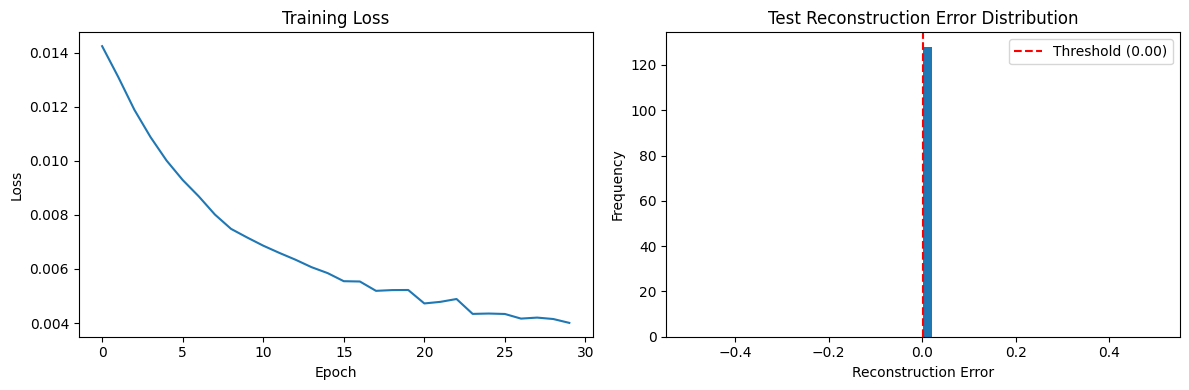


--- 程式碼執行完畢 ---
請查看訓練 Loss 曲線、測試集重建誤差分佈、以及評估結果 (如果測試集有真實標籤)。
異常判斷閾值設定為重建誤差的 85 百分位數，您可以調整這個閾值來改變異常偵測的靈敏度。


In [103]:
# 7. 繪製訓練 Loss 曲線 和 異常分數分佈 (可選)
# ------------------------------------
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.hist(reconstruction_errors_samples, bins=50)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.2f})')
plt.title('Test Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


print("\n--- 程式碼執行完畢 ---")
print("請查看訓練 Loss 曲線、測試集重建誤差分佈、以及評估結果 (如果測試集有真實標籤)。")
print("異常判斷閾值設定為重建誤差的 85 百分位數，您可以調整這個閾值來改變異常偵測的靈敏度。")

(1,
 '。 (二)金融機構 使用 AI與消費者直接互動 時，應適當揭露 。 \n六、促進永續發展 (一)金融機構在運用 AI系統時，應確保其發展策略及執行 與永續發展之原則相結合 ，包括減少經濟、社會等不平 等現象，保護自然環境，從而促進包容性成長、永續發\n展及社會福祉。 (二)金融機構在 AI系統運用過程中， 宜對一般員工 提供適 當之教育及培訓，使員工能適應 AI帶來之變革，並盡\n可能維護其 工作權益。')

In [ ]:
# from langchain_community.vectorstores import FAISS
# results = db.similarity_search("", k=3)
# for i in range(len(results)):
#   print(results[i])
#   print('='*10)
# # results[-1]

# retriever = db.as_retriever(search_type="mmr")
# docs = retriever.get_relevant_documents("what about SupTech")
# docs

In [ ]:
from langchain import PromptTemplate
from langchain.chains.retrieval_qa.base import RetrievalQA
template = """
role: 你是台灣的金融監督管理委員會之「窗口」，並且說著正體中文
question: {question}
answer: 回覆之前請檢視自己的答案，不可以捏照回答。並且詳盡可能回答你的客戶
context: {context}
temperature=0.0
"""


qa_prompt = PromptTemplate(
    input_variables=["question", "context"],
    template=template,
)


qa_chain = RetrievalQA.from_chain_type(llm,retriever=db.as_retriever(search_kwargs={'k':2}), chain_type_kwargs={"prompt": qa_prompt}, return_source_documents=True)
result = qa_chain({"question": myquery, "context": myapp})


print(qa_chain)


res=llm.invoke(prompt)
print(res)

NameError: name 'myquery' is not defined

**您好！我是台灣金融監督管理委員會的「窗口」，我專門為您解答有關監理科技 (SupTech) 的相關問題。**

**SuperTech 的定義是什麼？**

SuperTech 是指利用數碼技術和網路技術來建立和營運金融產品和服務的領域。

**SuperTech 的監理範圍是什麼？**

SuperTech 的監理範圍涵蓋但不限於：

* 產品設計與開發
* 交易處理
* 投資管理
* 客戶服務
* 安全與合規性

**SuperTech 的監理義務是什麼？**

SuperTech 的監理義務包括：

* 定期監控產品和服務的設計與開發過程
* 定期監控交易處理的過程
* 定期監控投資管理的過程
* 定期監控客戶服務的過程
* 定期監控安全與合規性的狀況
* 採取適當的措施來確保產品和服務安全與合規

**如何遵守 SuperTech 的監理義務？**

SuperTech 的監理義務可以透過以下方式實現：

* 確保產品和服務的設計與開發過程符合安全與合規標準
* 建立嚴格的交易處理流程
* 建立完善的投資管理制度
* 建立嚴格的客戶服務系統
* 建立完善的安全與合規性管理系統

**如何與 SuperTech 的監理相關聯繫？**

您可以透過以下方式與 SuperTech 的監理相關聯繫：

* 金管會網站上的資訊中心
* 金管會辦理的監理報告
* 金管會辦理的公開會議


## Test Library Setup

Next, let's create our test "library."

For simplicity's sake, let's say that our "library" is simply a **nested directory of `.epub` files**. We can easily see this solution generalizing to, say, a Calibre library with a `metadata.db` database file. We'll leave that extension as an exercise for the reader. 😇

Let's pull two `.epub` files from [Project Gutenberg](https://www.gutenberg.org/) for our library.

In [ ]:
!mkdir -p ".test/library/jane-austen"
!mkdir -p ".test/library/victor-hugo"
!wget https://www.gutenberg.org/ebooks/1342.epub.noimages -O ".test/library/jane-austen/pride-and-prejudice.epub"
!wget https://www.gutenberg.org/ebooks/135.epub.noimages -O ".test/library/victor-hugo/les-miserables.epub"

## RAG with LlamaIndex

RAG with LlamaIndex, at its core, consists of the following broad phases:

1. **Loading**, in which you tell LlamaIndex where your data lives and how to
   load it;
2. **Indexing**, in which you augment your loaded data to facilitate querying, e.g. with vector embeddings;
3. **Querying**, in which you configure an LLM to act as the query interface for
   your indexed data.

This explanation only scratches at the surface of what's possible with
LlamaIndex. For more in-depth details, I highly recommend reading the
["High-Level Concepts" page of the LlamaIndex
documentation](https://docs.llamaindex.ai/en/stable/getting_started/concepts.html).

### Loading

Naturally, let's start with the **loading** phase.

I mentioned before that LlamaIndex is designed specifically for RAG. This
immediately becomes obvious from its
[`SimpleDirectoryReader`](https://docs.llamaindex.ai/en/stable/module_guides/loading/simpledirectoryreader.html)
construct, which ✨ **magically** ✨ supports a whole host of multi-model file
types for free. Conveniently for us, `.epub` is in the supported set.

In [ ]:
from llama_index.core import SimpleDirectoryReader

loader = SimpleDirectoryReader(
    input_dir="./.test/",
    recursive=True,
    required_exts=[".epub"],
)

documents = loader.load_data()

`SimpleDirectoryReader.load_data()` converts our ebooks into a set of [`Document`s](https://docs.llamaindex.ai/en/stable/api/llama_index.core.schema.Document.html) for LlamaIndex to work with.

One important thing to note here is that the documents **have not been chunked at this stage** -- that will happen during indexing. Read on...

### Indexing

Next up after **loading** the data is to **index** it. This will allow our RAG pipeline to look up the relevant context for our query to pass to our LLM to **augment** their generated response. This is also where document chunking will take place.

[`VectorStoreIndex`](https://docs.llamaindex.ai/en/stable/module_guides/indexing/vector_store_index.html)
is a "default" entrypoint for indexing in LlamaIndex. By default,
`VectorStoreIndex` uses a simple, in-memory dictionary to store the indices, but
LlamaIndex also supports [a wide variety of vector storage
solutions](https://docs.llamaindex.ai/en/stable/module_guides/storing/vector_stores.html)
for you to graduate to as you scale.

<Tip>
By default, LlamaIndex uses a chunk size of 1024 and a chunk overlap of
20. For more details, see the [LlamaIndex
documentation](https://docs.llamaindex.ai/en/stable/optimizing/basic_strategies/basic_strategies.html#chunk-sizes).
</Tip>


Like mentioned before, we'll use the
[`BAAI/bge-small-en-v1.5`](https://huggingface.co/BAAI/bge-base-en-v1.5) to
generate our embeddings. By default, [LlamaIndex uses
OpenAI](https://docs.llamaindex.ai/en/stable/getting_started/starter_example.html)
(specifically `gpt-3.5-turbo`), which we'd like to avoid given our desire for a lightweight, locally-runnable end-to-end solution.

Thankfully, LlamaIndex supports retrieving embedding models from Hugging Face through the convenient `HuggingFaceEmbedding` class, so we'll use that here.

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

embedding_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

We'll pass that in to `VectorStoreIndex` as our embedding model to circumvent the OpenAI default behavior.

In [ ]:
from llama_index.core import VectorStoreIndex

index = VectorStoreIndex.from_documents(
    documents,
    embed_model=embedding_model,
)

### Querying

Now for the final piece of the RAG puzzle -- wiring up the query layer.

We'll use Llama 2 for the purposes of this recipe, but I encourage readers to play around with different models to see which produces the "best" responses here.

First let's start up the Ollama server. Unfortunately, there is no support in the [Ollama Python client](https://github.com/ollama/ollama-python) for actually starting and stopping the server itself, so we'll have to pop out of Python land for this.

In a separate terminal, run: `ollama serve`. Remember to terminate this after we're done here!

Now let's hook Llama 2 up to LlamaIndex and use it as the basis of our query engine.

In [ ]:
from llama_index.llms.ollama import Ollama

llama = Ollama(
    model="llama2",
    request_timeout=40.0,
)

query_engine = index.as_query_engine(llm=llama)

## Final Result

With that, our basic RAG librarian is set up and we can start asking questions about our library. For example:

In [ ]:
print(query_engine.query("What are the titles of all the books available? Show me the context used to derive your answer."))

Based on the context provided, there are two books available:

1. "Pride and Prejudice" by Jane Austen
2. "Les Misérables" by Victor Hugo

The context used to derive this answer includes:

* The file path for each book, which provides information about the location of the book files on the computer.
* The titles of the books, which are mentioned in the context as being available for reading.
* A list of words associated with each book, such as "epub" and "notebooks", which provide additional information about the format and storage location of each book.


In [ ]:
print(query_engine.query("Who is the main character of 'Pride and Prejudice'?"))

The main character of 'Pride and Prejudice' is Elizabeth Bennet.


## Conclusion and Future Improvements

We've demonstrated how to build a basic RAG-based "librarian" that runs entirely locally, even on Apple silicon Macs. In doing so, we've also carried out a "grand tour" of LlamaIndex and how it streamlines the process of setting up RAG-based applications.

That said, we've really only scratched the surface of what's possible here. Here are some ideas of how to refine and build upon this foundation.

### Forcing Citations

To guard against the risk of our librarian hallucinating, how might we require that it provide citations for everything that it says?

### Using Extended Metadata

Ebook library management solutions like [Calibre](https://calibre-ebook.com/) create additional metadata for ebooks in a library. This can provide information such as publisher or edition that might not be readily available in the text of the book itself. How could we extend our RAG pipeline to account for additional sources of information that aren't `.epub` files?

### Efficient Indexing

If we were to collect everything we built here into a script/executable, the resulting script would re-index our library on each invocation. For our tiny test library of two files, this is "fine," but for any library of non-trivial size this will very quickly become annoying for users. How could we persist the embedding indices and only update them when the contents of the library have meaningfully changed, e.g. new books have been added?